#PolynomialFeatures - Use in machine learning?

`PolynomialFeatures` is a preprocessing transformation from scikit-learn that generates polynomial and interaction terms. It allows us to model nonlinear relationships using linear models by transforming the original features.

We use polynomial features when:
- The relationship between features and target is nonlinear
- We want to capture complex interactions between variables
- We need to maintain model interpretability while handling nonlinearity
- We want to apply regularization techniques to nonlinear problems

For example, it transforms a single feature `x` into `[x, x², x³, ...]` for a specified degree, enabling a linear model to fit curved patterns in the data.



# How does PolynomialFeatures transform the feature matrix?

`PolynomialFeatures` transforms an input matrix with n features into a new matrix containing:
- The original features
- Polynomial terms for each feature up to the specified degree
- Interaction terms between different features

For example, with 2 features [x₁, x₂] and degree=2:
- Original features: [x₁, x₂]
- After transformation: [1, x₁, x₂, x₁², x₁x₂, x₂²]

The transformation follows this formula for each combination:
```
(x₁ + x₂ + ... + xₙ)ᵈ
```
where d is the polynomial degree.

Key parameters:
- `degree`: Maximum polynomial degree (default=2)
- `interaction_only`: If True, only interaction features are produced (no powers of single features)
- `include_bias`: Whether to include a bias column (constant term) in the output (default=True)

# time and space complexity of PolynomialFeatures

The complexity of `PolynomialFeatures` is significant, especially as degree or number of features increases:

**Time complexity**:
- Transformation: **O(n_samples × n_features^degree)**
- The number of output features is **O(n_features^degree)**

**Space complexity**:
- O(n_samples × n_features^degree)

For high-dimensional data or high polynomial degrees, this can lead to:
- Combinatorial explosion of features
- Memory issues with large datasets
- Increased computational cost
- Higher risk of overfitting

**Practical example**: With 10 features and degree=3, you end up with 286 features after transformation. This is why feature selection or regularization is often used alongside polynomial features.


# How polynomial regression help with nonlinear data - its limitations

Polynomial regression helps with nonlinear data by:
- Capturing curved relationships between variables
- Maintaining the simplicity and interpretability of linear models
- Allowing for easy model fitting with ordinary least squares
- Working with existing regularization techniques

**Limitations**:
1. **Overfitting**: Higher degree polynomials can fit noise in the data
2. **Extrapolation issues**: Polynomials behave poorly outside the range of training data
3. **Multicollinearity**: Polynomial terms are often highly correlated
4. **Curse of dimensionality**: Exponential increase in features with degree
5. **Feature interpretation**: Coefficients become harder to interpret with higher degrees

To address these limitations, we typically use:
- Cross-validation to find optimal degree
- Regularization (Ridge/Lasso) to prevent overfitting
- Feature scaling before generating polynomial features

# Choosing optimal polynomial degree for model

Selecting the optimal polynomial degree involves balancing model complexity against overfitting:

**Methods to find optimal degree**:
1. **Cross-validation**: Use k-fold CV to evaluate different degrees
   ```python
   param_grid = {'poly_features__degree': range(1, 11)}
   grid_search = GridSearchCV(polynomial_pipeline, param_grid, cv=5)
   ```

2. **Validation curves**: Plot training and validation scores against degree
   ```python
   degrees = range(1, 15)
   train_scores, test_scores = validation_curve(
       polynomial_pipeline, X, y, param_name="poly_features__degree", 
       param_range=degrees, cv=5)
   ```

3. **Information criteria**: Use AIC or BIC to penalize complexity
   ```python
   # Lower AIC/BIC values indicate better models
   aic_scores = [calculate_aic(model, X_test, y_test) for model in models]
   ```

4. **Regularization path**: Use regularization to automatically reduce impact of higher-order terms
   ```python
   alphas = np.logspace(-6, 6, 13)
   ridge_cv = RidgeCV(alphas=alphas, cv=5)
   ```

The optimal degree depends on:
- Sample size (more data can support higher degrees)
- Signal-to-noise ratio in data
- Domain-specific knowledge about the relationship
- Computational constraints

# Difference between interaction_only=True and interaction_only=False in PolynomialFeatures

The `interaction_only` parameter controls whether we include powers of individual features:

**interaction_only=False (default)**:
- Includes all polynomial terms up to the specified degree
- For features [a, b] with degree=2: [1, a, b, a², ab, b²]
- Captures both interaction effects and nonlinear effects of individual features

**interaction_only=True**:
- Only includes interaction terms between different features
- For features [a, b] with degree=2: [1, a, b, ab]
- Excludes powers of individual features (a², b²)
- Useful when you know individual features have linear relationships, but interactions may be important

**When to use interaction_only=True**:
- When you want to test specifically for interaction effects
- To reduce model complexity while capturing feature interactions
- When domain knowledge suggests interactions are more important than nonlinear effects of individual features

# How PolynomialFeatures works with regularization techniques like Ridge or Lasso

Combining polynomial features with regularization is a powerful approach to handle nonlinearity while preventing overfitting:

**Benefits of combining polynomials with regularization**:
1. **Controlled complexity**: Regularization automatically down-weights less important polynomial terms
2. **Feature selection**: Lasso can eliminate irrelevant polynomial terms entirely
3. **Stable coefficients**: Ridge helps with the multicollinearity inherent in polynomial features
4. **Better generalization**: Prevents overfitting that often occurs with high-degree polynomials

**Implementation best practices**:
1. **Scale before generating polynomials**: 
   ```python
   pipeline = Pipeline([
       ('scaler', StandardScaler()),
       ('poly', PolynomialFeatures(degree=3)),
       ('ridge', Ridge(alpha=0.1))
   ])
   ```

2. **Cross-validate both degree and regularization strength**:
   ```python
   param_grid = {
       'poly__degree': [1, 2, 3, 4],
       'ridge__alpha': [0.001, 0.01, 0.1, 1.0, 10.0]
   }
   ```

3. **Consider stronger regularization for higher degrees**:
   As polynomial degree increases, regularization needs typically increase proportionally.

The code examples demonstrate how regularization prevents the wild oscillations that high-degree polynomials might otherwise produce, especially near the boundaries of the data range.

# Warning signs of overfitting when using polynomial features

Key indicators of overfitting with polynomial features include:

1. **Large gap between training and test performance**:
   - High R² on training data but poor R² on test data
   - Learning curves show wide separation between training and validation scores

2. **Coefficient behavior**:
   - Unusually large coefficient values (often with alternating signs)
   - Coefficients for higher-degree terms being larger than lower-degree terms
   - High variance in coefficients when retrained on different subsets

3. **Model predictions**:
   - Erratic behavior, especially near the boundaries of training data
   - Unrealistic predictions when extrapolating
   - Excessive wiggling in the fitted curve between data points

4. **Cross-validation issues**:
   - High variance in cross-validation scores
   - Performance degrades sharply with small changes to the training set

To diagnose overfitting:
```python
# Check coefficient magnitudes
plt.barh(feature_names, model.coef_)

# Learning curves
plot_learning_curve(model, "Learning Curves", X, y, cv=5)

# Plot predictions vs actual data
plt.scatter(X, y)
plt.plot(X_sorted, model.predict(X_poly_sorted), 'r-')
```

The solution is usually to:
1. Reduce polynomial degree
2. Increase regularization strength
3. Gather more training data

# Model with Pipeline

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.metrics import mean_squared_error, r2_score


In [12]:
# Create nonlinear data for demonstration
np.random.seed(42)
X = np.sort(5 * np.random.rand(100, 1), axis=0)
y = np.sin(X).ravel() + np.random.normal(0, 0.1, X.shape[0])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
pd.DataFrame(X).head()

,0
0,0.027611
1,0.102922
2,0.127096
3,0.171943
4,0.226136


In [15]:
pd.DataFrame(y).head()

,0
0,0.036312
1,0.072840
2,0.135930
3,-0.027660
4,0.202247


In [17]:
# 1. PolynomialFeatures transformer
# ------------------------------------------------------

# Create polynomial features
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

print(f"Original X shape: {X_train.shape}")
print(f"Transformed X shape after polynomial features: {X_poly_train.shape}")
print(f"Feature names: {poly.get_feature_names_out(['x'])}")

# Fit linear regression with polynomial features
model = LinearRegression()
model.fit(X_poly_train, y_train)

y_pred = model.predict(X_poly_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nPolynomial regression results:")
print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")
print(f"Coefficients: {model.coef_}")
print(f"Intercept: {model.intercept_:.4f}")

Original X shape: (70, 1)
Transformed X shape after polynomial features: (70, 3)
Feature names: ['x' 'x^2' 'x^3']

Polynomial regression results:
MSE: 0.0090
R²: 0.9817
Coefficients: [ 1.96822445 -0.89727356  0.09455103]
Intercept: -0.2647


In [18]:
pd.DataFrame(X_poly_train).head()

,0,1,2
0,0.442463,0.195773,0.086622
1,2.159725,4.664412,10.073849
2,4.143688,17.170146,71.147722
3,1.061696,1.127197,1.196741
4,4.697495,22.066457,103.657063


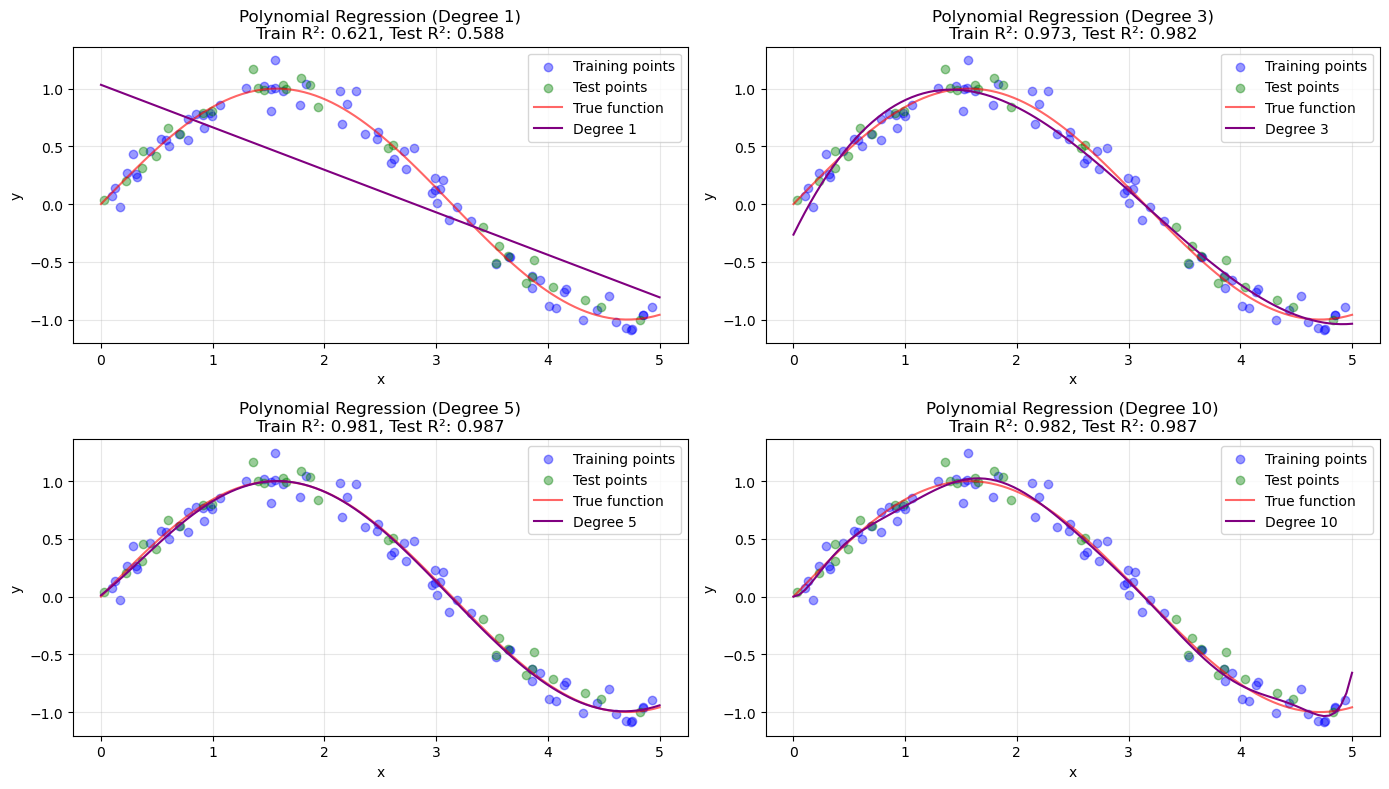

In [19]:
# 2: Visualize polynomial regression with different degrees
# -----------------------------------------------------------------

degrees = [1, 3, 5, 10]
plt.figure(figsize=(14, 8))

X_plot = np.linspace(0, 5, 100).reshape(-1, 1)
y_true = np.sin(X_plot).ravel()

for i, degree in enumerate(degrees):
    ax = plt.subplot(2, 2, i+1)
    
    # Create pipeline
    polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([
        ("polynomial_features", polynomial_features),
        ("linear_regression", linear_regression)
    ])
    
    # Fit and predict
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_plot)
    
    # Get scores
    train_score = pipeline.score(X_train, y_train)
    test_score = pipeline.score(X_test, y_test)
    
    # Plot
    plt.scatter(X_train, y_train, label="Training points", color="blue", alpha=0.4)
    plt.scatter(X_test, y_test, label="Test points", color="green", alpha=0.4)
    plt.plot(X_plot, y_true, label="True function", color="red", alpha=0.6)
    plt.plot(X_plot, y_pred, label=f"Degree {degree}", color="purple")
    plt.title(f"Polynomial Regression (Degree {degree})\nTrain R²: {train_score:.3f}, Test R²: {test_score:.3f}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend(loc="best")
    plt.grid(True, alpha=0.3)

plt.tight_layout()

c:\Users\shanthi\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=3.78918e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\shanthi\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=3.32052e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\shanthi\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=3.43026e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\shanthi\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=3.37276e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


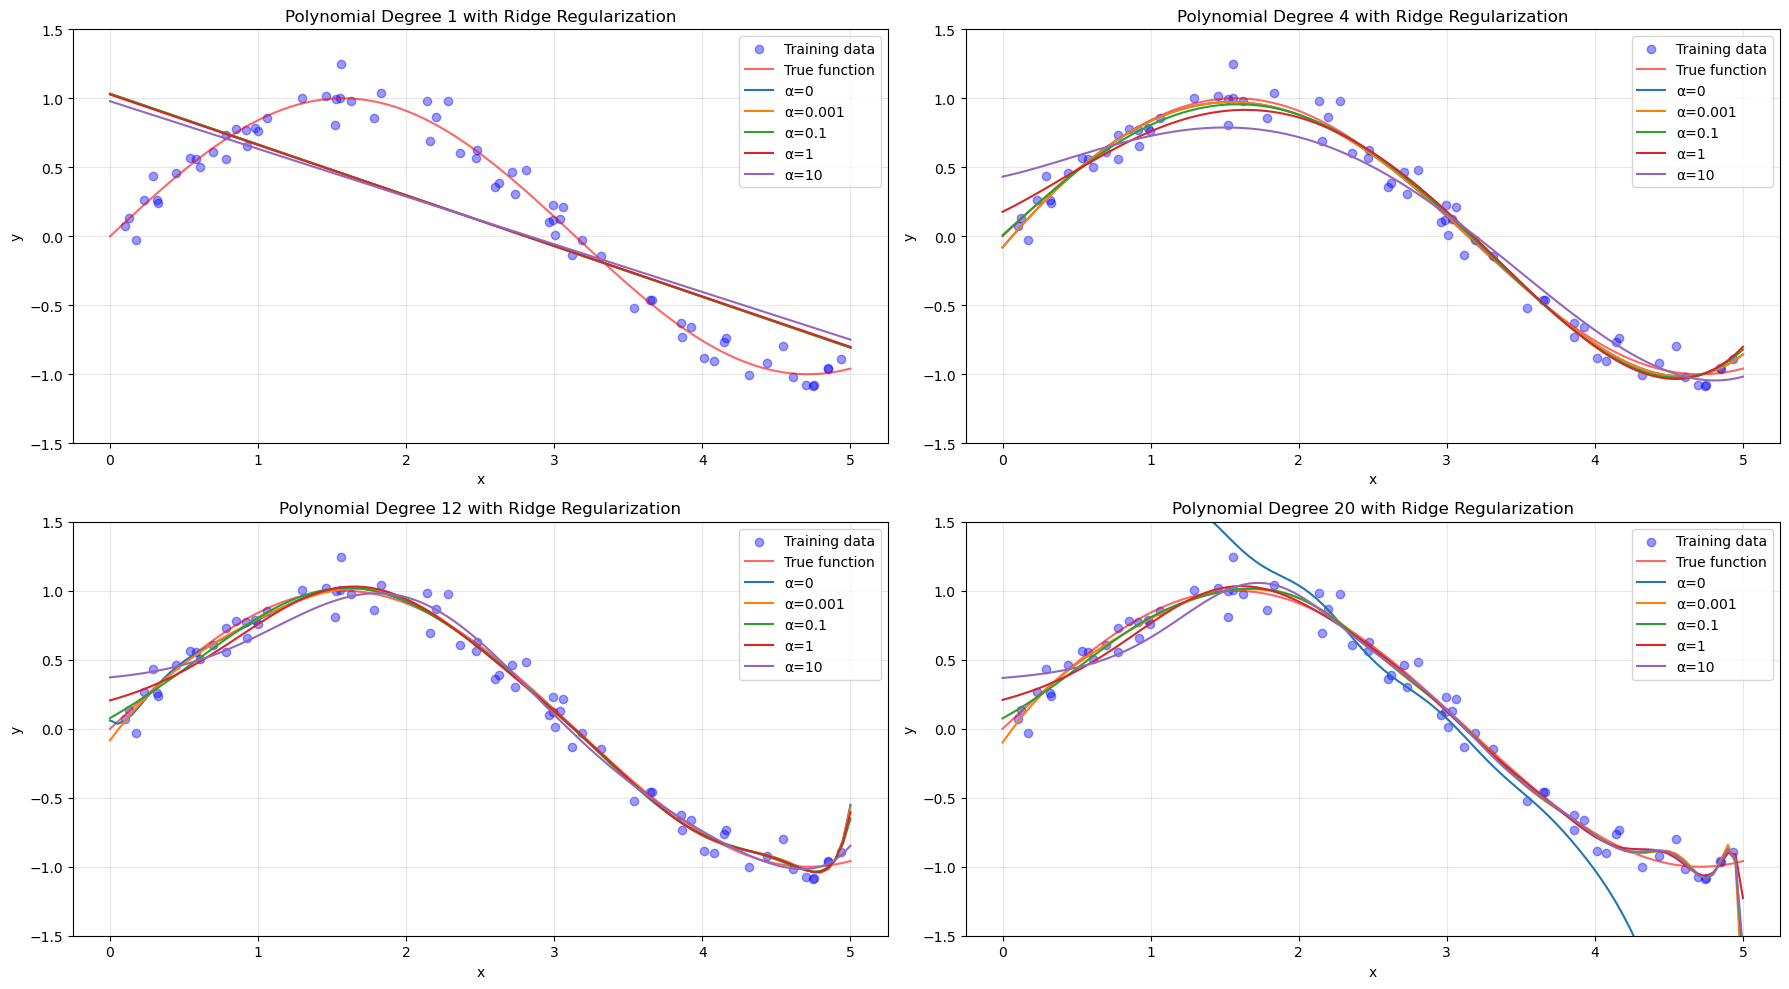

In [20]:
# 3: Overfitting with polynomial features and regularization
# ------------------------------------------------------------------

degrees = [1, 4, 12, 20]
alphas = [0, 0.001, 0.1, 1, 10]

plt.figure(figsize=(18, 10))

for i, degree in enumerate(degrees):
    ax = plt.subplot(2, 2, i+1)
    
    # Prepare polynomial features
    X_poly = PolynomialFeatures(degree=degree, include_bias=False).fit_transform(X)
    X_poly_train, X_poly_test, y_train_poly, y_test_poly = train_test_split(
        X_poly, y, test_size=0.3, random_state=42)
    
    # Plot training data
    plt.scatter(X_train, y_train, color='blue', alpha=0.4, label="Training data")
    
    # Plot true function
    X_plot = np.linspace(0, 5, 100).reshape(-1, 1)
    y_true = np.sin(X_plot).ravel()
    plt.plot(X_plot, y_true, color='red', alpha=0.6, label="True function")
    
    # Test different regularization strengths
    for alpha in alphas:
        model = Ridge(alpha=alpha)
        model.fit(X_poly_train, y_train_poly)
        
        # Transform X_plot for prediction
        X_plot_poly = PolynomialFeatures(degree=degree, include_bias=False).fit_transform(X_plot)
        y_plot = model.predict(X_plot_poly)
        
        plt.plot(X_plot, y_plot, label=f"α={alpha}", linestyle='-')
    
    plt.title(f"Polynomial Degree {degree} with Ridge Regularization")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.ylim(-1.5, 1.5)
    plt.legend(loc="best")
    plt.grid(True, alpha=0.3)

plt.tight_layout()

Fitting 5 folds for each of 49 candidates, totalling 245 fits

Grid Search Results:
Best parameters: {'poly_features__degree': 5, 'ridge__alpha': 0}
Best CV score: 0.0111 (MSE)


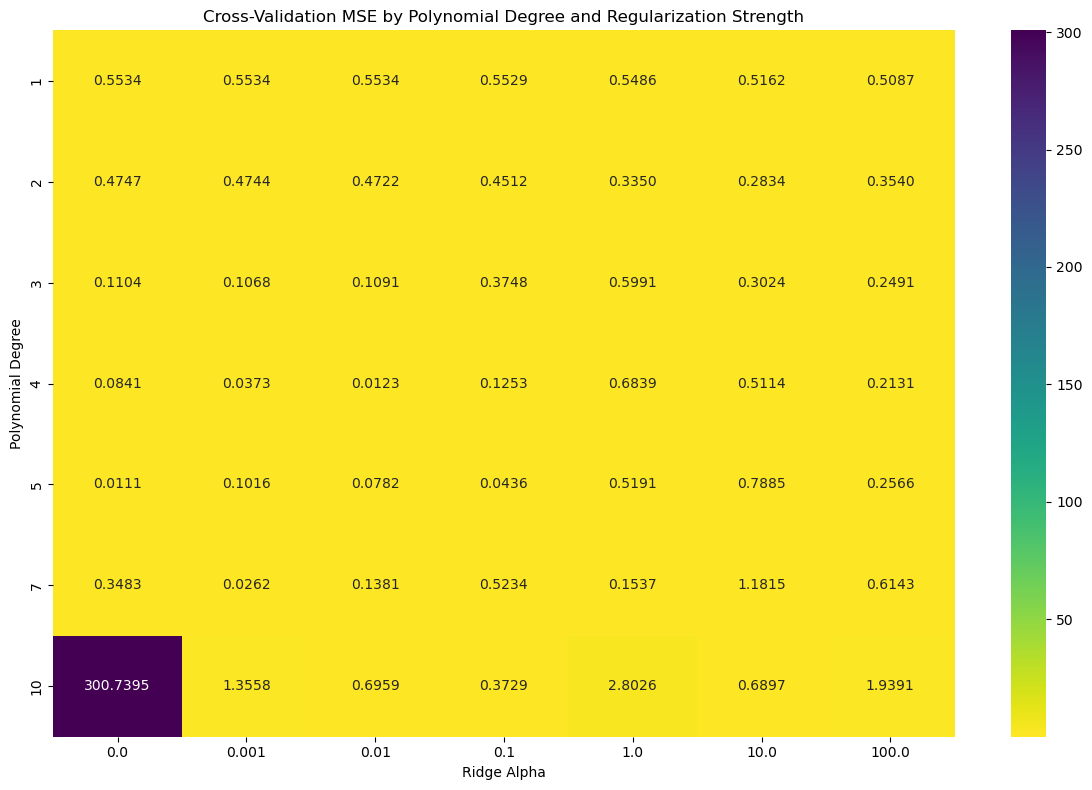

In [22]:
# 4: Find optimal degree and regularization with cross-validation
# -----------------------------------------------------------------------

# Set up pipeline
polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(include_bias=False)),
    ("scaler", StandardScaler()),
    ("ridge", Ridge())
])

# Set parameters to search
param_grid = {
    "poly_features__degree": [1, 2, 3, 4, 5, 7, 10],
    "ridge__alpha": [0, 0.001, 0.01, 0.1, 1, 10, 100]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    polynomial_regression,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X, y)

print("\nGrid Search Results:")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {-grid_search.best_score_:.4f} (MSE)")

# Plot the results of grid search
results = pd.DataFrame(grid_search.cv_results_)
results = results.sort_values("rank_test_score")

# Extract parameters of interest
degree_values = param_grid["poly_features__degree"]
alpha_values = param_grid["ridge__alpha"]

# Create heatmap of results
pivot_table = pd.DataFrame(
    index=degree_values,
    columns=alpha_values,
    data=np.nan
)

for degree in degree_values:
    for alpha in alpha_values:
        value = -results[
            (results["param_poly_features__degree"] == degree) & 
            (results["param_ridge__alpha"] == alpha)
        ]["mean_test_score"].values[0]
        pivot_table.loc[degree, alpha] = value

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="viridis_r")
plt.title("Cross-Validation MSE by Polynomial Degree and Regularization Strength")
plt.xlabel("Ridge Alpha")
plt.ylabel("Polynomial Degree")
plt.tight_layout()

<module 'matplotlib.pyplot' from 'c:\\Users\\shanthi\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

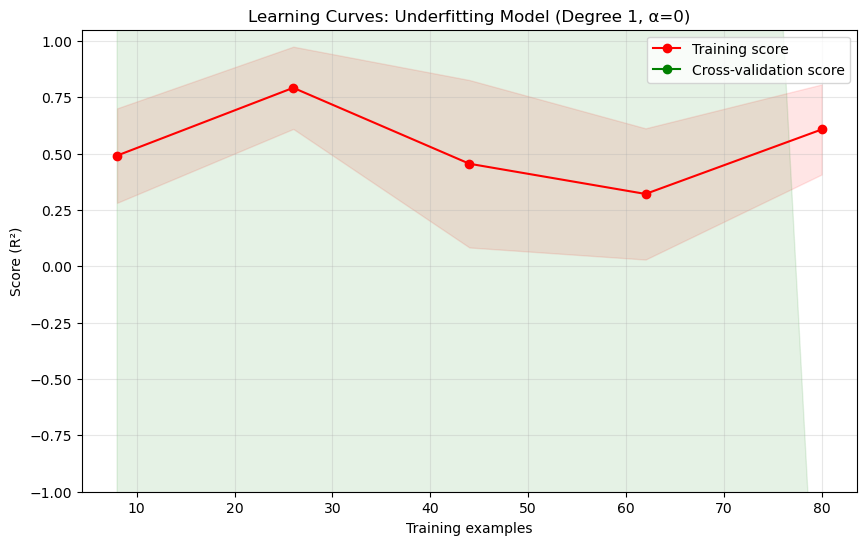

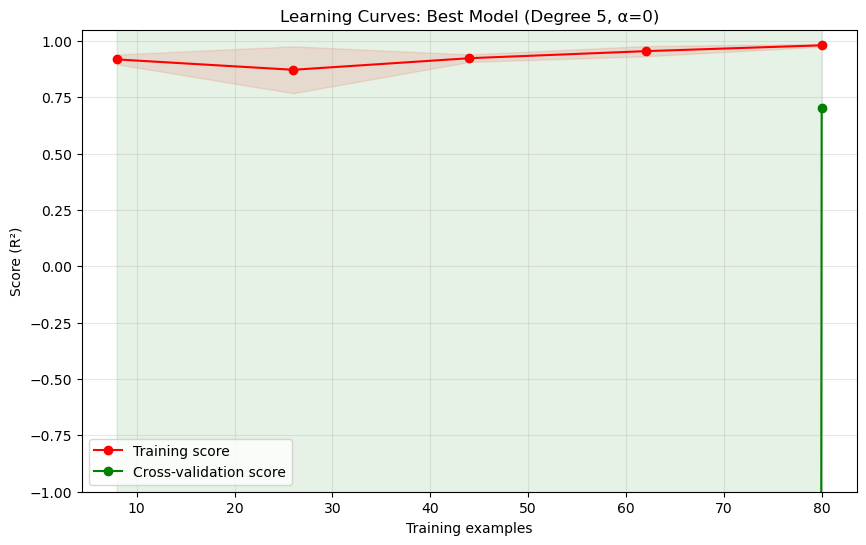

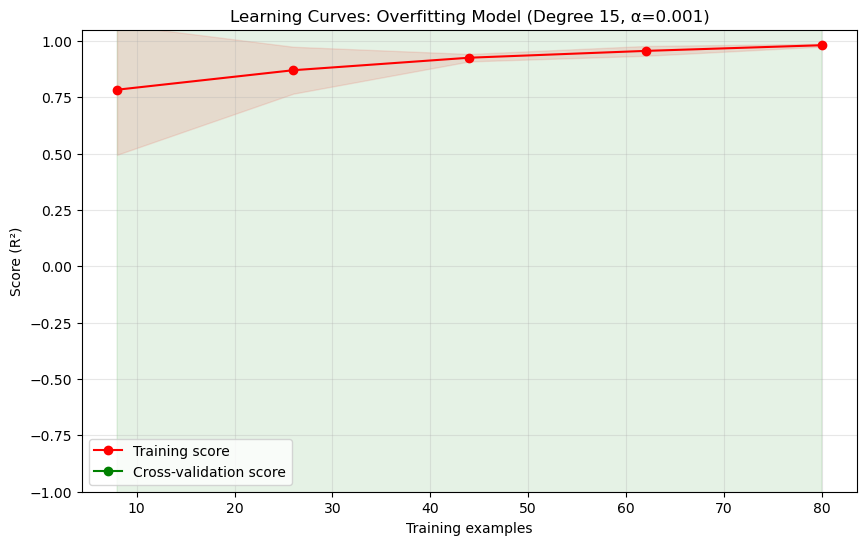

In [23]:
# 5: Learning curves to diagnose bias vs. variance
# --------------------------------------------------------

# Get the best model from grid search
best_degree = grid_search.best_params_["poly_features__degree"]
best_alpha = grid_search.best_params_["ridge__alpha"]

# Create models with different degrees
best_model = Pipeline([
    ("poly", PolynomialFeatures(degree=best_degree, include_bias=False)),
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=best_alpha))
])

underfitting_model = Pipeline([
    ("poly", PolynomialFeatures(degree=1, include_bias=False)),
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=best_alpha))
])

overfitting_model = Pipeline([
    ("poly", PolynomialFeatures(degree=15, include_bias=False)),
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=0.001))
])

# Function to plot learning curves
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=5,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score (R²)")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring="r2")
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid(True, alpha=0.3)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    
    return plt

# Plot learning curves for different models
plot_learning_curve(
    underfitting_model, 
    f"Learning Curves: Underfitting Model (Degree 1, α={best_alpha})",
    X, y, ylim=(-1, 1.05), cv=5
)

plot_learning_curve(
    best_model, 
    f"Learning Curves: Best Model (Degree {best_degree}, α={best_alpha})",
    X, y, ylim=(-1, 1.05), cv=5
)

plot_learning_curve(
    overfitting_model, 
    "Learning Curves: Overfitting Model (Degree 15, α=0.001)",
    X, y, ylim=(-1, 1.05), cv=5
)


Interaction Features Results:
R² without interactions: 0.8824
R² with interactions: 0.9801

Features without interactions:
  x1: 6.0609
  x2: 0.8539
  Intercept: -2.7337

Features with interactions:
  x1: 2.0293
  x2: -2.5816
  x1^2: 0.0340
  x1 x2: 3.9379
  x2^2: -0.2032
  Intercept: 0.8646


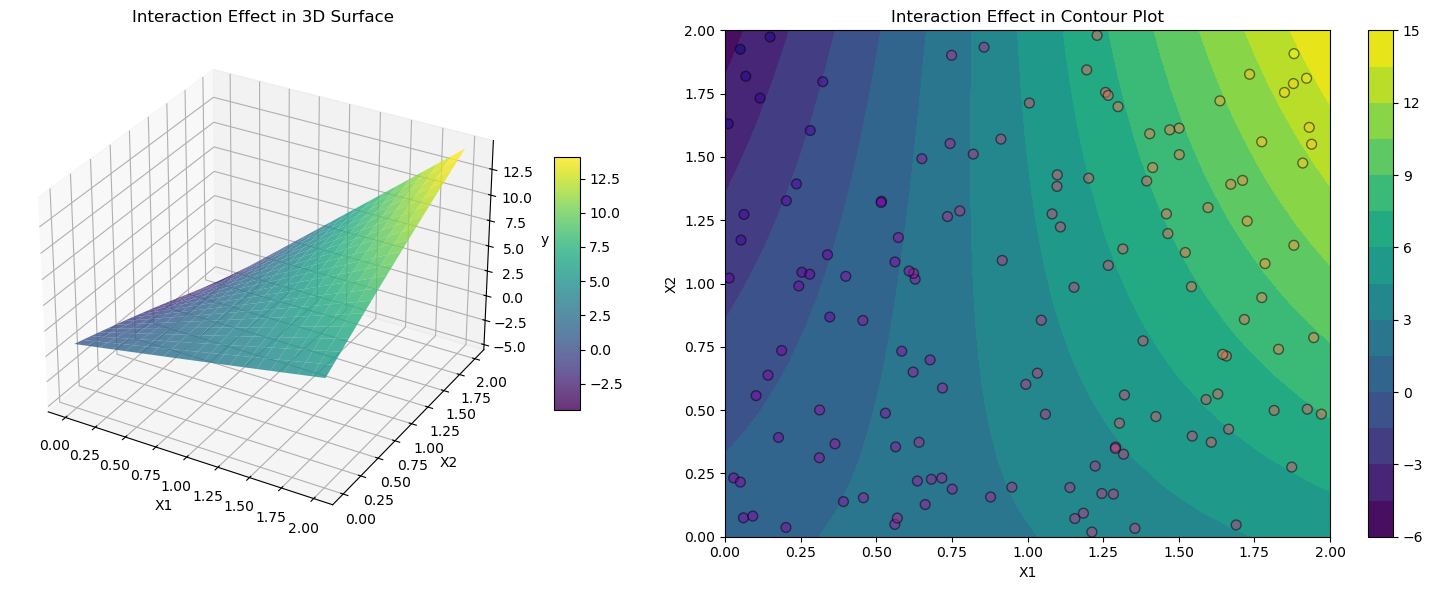

In [ ]:

# 6: Interaction features and their importance
# ----------------------------------------------------

# Generate data with interaction effects
np.random.seed(42)
X_interaction = np.random.rand(200, 2) * 2  # Two features between 0-2
# True relationship has interaction term x1*x2
y_interaction = 1 + 2*X_interaction[:, 0] - 3*X_interaction[:, 1] + 4*X_interaction[:, 0]*X_interaction[:, 1] + np.random.normal(0, 0.5, 200)

# Split data
X_train_int, X_test_int, y_train_int, y_test_int = train_test_split(
    X_interaction, y_interaction, test_size=0.3, random_state=42)

# Model without interactions
model_no_int = LinearRegression()
model_no_int.fit(X_train_int, y_train_int)
y_pred_no_int = model_no_int.predict(X_test_int)
r2_no_int = r2_score(y_test_int, y_pred_no_int)

# Model with interactions
poly_int = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_train_poly_int = poly_int.fit_transform(X_train_int)
X_test_poly_int = poly_int.transform(X_test_int)

model_with_int = LinearRegression()
model_with_int.fit(X_train_poly_int, y_train_int)
y_pred_with_int = model_with_int.predict(X_test_poly_int)
r2_with_int = r2_score(y_test_int, y_pred_with_int)

# Print results
print("\nInteraction Features Results:")
print(f"R² without interactions: {r2_no_int:.4f}")
print(f"R² with interactions: {r2_with_int:.4f}")
print("\nFeatures without interactions:")
for i, coef in enumerate(model_no_int.coef_):
    print(f"  x{i+1}: {coef:.4f}")
print(f"  Intercept: {model_no_int.intercept_:.4f}")

print("\nFeatures with interactions:")
feature_names = poly_int.get_feature_names_out(['x1', 'x2'])
for name, coef in zip(feature_names, model_with_int.coef_):
    print(f"  {name}: {coef:.4f}")
print(f"  Intercept: {model_with_int.intercept_:.4f}")

# Visualize the interaction effect
x1_range = np.linspace(0, 2, 20)
x2_range = np.linspace(0, 2, 20)
X1, X2 = np.meshgrid(x1_range, x2_range)
X_grid = np.vstack([X1.ravel(), X2.ravel()]).T
X_grid_poly = poly_int.transform(X_grid)
Z = model_with_int.predict(X_grid_poly).reshape(X1.shape)

fig = plt.figure(figsize=(16, 6))

# 3D surface plot
ax1 = fig.add_subplot(121, projection='3d')
surf = ax1.plot_surface(X1, X2, Z, cmap='viridis', alpha=0.8)
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
ax1.set_zlabel('y')
ax1.set_title('Interaction Effect in 3D Surface')
fig.colorbar(surf, ax=ax1, shrink=0.5, aspect=10)

# Contour plot
ax2 = fig.add_subplot(122)
contour = ax2.contourf(X1, X2, Z, cmap='viridis', levels=15)
ax2.set_xlabel('X1')
ax2.set_ylabel('X2')
ax2.set_title('Interaction Effect in Contour Plot')
fig.colorbar(contour, ax=ax2)

# Scatter points
ax2.scatter(X_train_int[:, 0], X_train_int[:, 1], c=y_train_int, 
           s=50, alpha=0.5, edgecolor='k', cmap='plasma')

plt.tight_layout()
plt.show()